In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [36]:
#import test and train data
train = pd.read_csv('../datasets/train_poly')
test = pd.read_csv('../datasets/test_cleaned.csv')

prediction_id = test['id']

In [37]:
#create our X and y for linear regression

X = train.drop(columns = ['saleprice'])
y = train['saleprice']

In [38]:
#instantiate the model and check the crossval scores to evaluate performance
lr = LinearRegression()
scores = cross_val_score(lr, X, y)

In [39]:
#checking to see if log transforming the saleprice variable helps with fit, it does not.

X = train.drop(columns = ['saleprice'])
ylog = np.log(train['saleprice'])
lr_log = LinearRegression()
log_scores = cross_val_score(lr_log, X, ylog)

In [40]:
#name and check our model score
lr_fitted = lr.fit(X, y)

In [41]:
lr_fitted.score(X, y)

0.9181144953563172

### Create Predictions

In [42]:
predictions = lr_fitted.predict(X)

In [43]:
from sklearn.preprocessing import PolynomialFeatures
poly_variables = ['overall_qual','gr_liv_area','total_bsmt_sf','garage_area','exter_qual']

In [44]:
#subset data
test_poly_variables = test[poly_variables]

In [45]:
#instantiate poly function
poly = PolynomialFeatures(
    degree = 2, interaction_only = False, include_bias = False)

prediction_polys = pd.DataFrame(
    poly.fit_transform(test_poly_variables), 
    columns = poly.get_feature_names(poly_variables))


In [46]:
#drop the old variables
prediction_polys.drop(columns = poly_variables, inplace = True)

In [47]:
#add the poly terms to the test data
test = pd.concat([prediction_polys, test], axis = 1)

In [48]:
#drop the columns from the test data that we will not be using in the model
train_cols = list(train.columns)
test_cols = list(test.columns)

to_drop = []

for col in test_cols:
    if col not in train_cols:
        to_drop.append(col)

In [49]:
test.drop(columns = to_drop, inplace = True)
test.drop(columns = ['saleprice'], inplace = True)

In [50]:
# create predictions
preds = lr_fitted.predict(test)

In [51]:
#create submission DF
poly_submission = pd.DataFrame(zip(prediction_id, preds))

poly_submission.rename(columns = {0:'Id', 1:'SalePrice'}, inplace = True)

poly_submission.to_csv(
    '../submission predictions/poly_submission.csv', index = False)

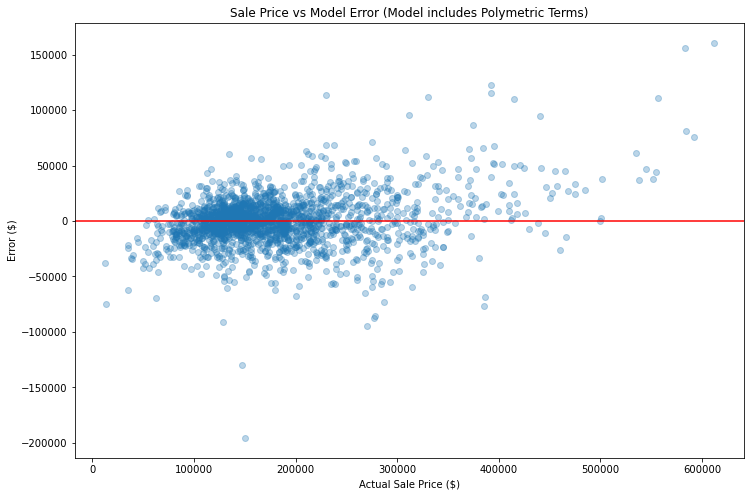

In [52]:
#plot the residuals

poly_error = y - lr_fitted.predict(X)
plt.figure(figsize=(12,8))
plt.scatter(y, poly_error, alpha = 0.3)
plt.axhline(0, color = 'red')
plt.title('Sale Price vs Model Error (Model includes Polymetric Terms)')
plt.ylabel('Error ($)')
plt.xlabel('Actual Sale Price ($)')
plt.savefig('../figures/saleprice_error_interaction', transparent = True)

This is a big improvement over some of the earlier models. The distribution of errors is much more even, but still displays a small amount of underestimating when it comes to higher value homes. Initially I thought I might try log transforming the data, but after including the polynomial terms it no longer seems necessary.

<ipython-input-53-ce5677e82a5c>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


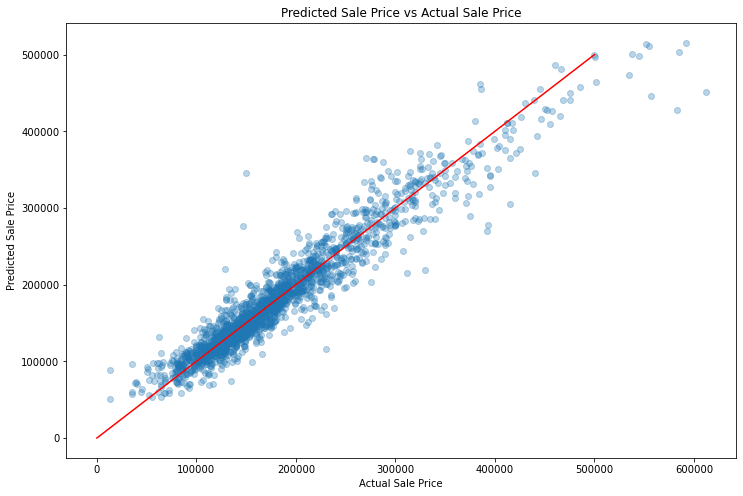

In [53]:
#check model predictions against acutal price

plt.figure(figsize=(12,8))
plt.scatter(y, lr_fitted.predict(X), alpha = 0.3)
plt.title('Predicted Sale Price vs Actual Sale Price')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

ax = plt.axes()
ax.plot([0,500000], [0,500000], color = 'red')
plt.savefig('../figures/actual_predicted_interaction', transparent = True)

Again, This graph indicates that our model is performing quite well. All of our predictions follow closely along the red line which indicates that our predicted price is consistently in line with the actual price. 

In [54]:
#Model Coefficients

coefficients = pd.DataFrame(zip(X.columns, lr_fitted.coef_))

In [55]:
coefficients.sort_values(1)

,0,1
14,exter_qual^2,-21439.431853
24,exter_qual,-21439.431853
16,overall_qual,-8060.242336
40,neighborhood_NoRidge,-4909.764585
26,bsmt_qual,-3671.350686
21,exterior_1st,-3167.605931
29,electrical,-2233.051084
22,mas_vnr_type,-1864.151843
0,overall_qual^2,-661.571009
35,garage_area,-45.767519


In [56]:
np.mean(scores)

0.9090227023988845

In [57]:
np.std(scores)

0.010253411311818054

In [58]:
'regular: {:.2f} +/- {:.2f}'.format(np.mean(scores), 2*np.std(scores))

'regular: 0.91 +/- 0.02'

In [59]:
'log: {:.2f} +/- {:.2f}'.format(np.mean(log_scores), 2*np.std(log_scores))

'log: 0.89 +/- 0.04'

### run a lasso regression on the model with poly terms

In [60]:
#create X and y
X = train.drop(columns = ['saleprice'])
y = train['saleprice']

#Scale the data
ss = StandardScaler()
Z_train = ss.fit_transform(X)

#Create a list of possible alphas
lasso_alphas = np.logspace(0, 15, 200)

#Instantiate our Lasso Model
lasso_cv = LassoCV(alphas = lasso_alphas, cv = 5, max_iter = 50000)

#train our model
lasso_cv.fit(Z_train, y)

LassoCV(alphas=array([1.00000000e+00, 1.18953407e+00, 1.41499130e+00, 1.68318035e+00,
       2.00220037e+00, 2.38168555e+00, 2.83309610e+00, 3.37006433e+00,
       4.00880633e+00, 4.76861170e+00, 5.67242607e+00, 6.74754405e+00,
       8.02643352e+00, 9.54771611e+00, 1.13573336e+01, 1.35099352e+01,
       1.60705282e+01, 1.91164408e+01, 2.27396575e+01, 2.70495973e+01,
       3.21764175e+01, 3.82749448e+0...
       1.84642494e+13, 2.19638537e+13, 2.61267523e+13, 3.10786619e+13,
       3.69691271e+13, 4.39760361e+13, 5.23109931e+13, 6.22257084e+13,
       7.40196000e+13, 8.80488358e+13, 1.04737090e+14, 1.24588336e+14,
       1.48202071e+14, 1.76291412e+14, 2.09704640e+14, 2.49450814e+14,
       2.96730241e+14, 3.52970730e+14, 4.19870708e+14, 4.99450512e+14,
       5.94113398e+14, 7.06718127e+14, 8.40665289e+14, 1.00000000e+15]),
        cv=5, max_iter=50000)

In [61]:
lasso_cv.alpha_

91.15888299750819

In [62]:
cross_val_score(lasso_cv, Z_train, y)

array([0.89339875, 0.9068685 , 0.92302797, 0.91316916, 0.91085266])

In [63]:
#confidence interval for r2 for the lasso regression with poly terms
mean = cross_val_score(lasso_cv, X, y).mean()
std = np.std(cross_val_score(lasso_cv, X, y))
mean - 2*std, mean + 2* std

(0.8887879789421155, 0.9290399040111589)

In [64]:
#creating a list of the coefficients
lasso_coefficients = list(zip(X.columns, lasso_cv.coef_))

In [65]:
zero_terms = []

for var_coef in lasso_coefficients:
    if var_coef[1] == 0:
        zero_terms.append(var_coef[0])

In [66]:
zero_terms

['overall_qual^2',
 'overall_qual exter_qual',
 'gr_liv_area^2',
 'total_bsmt_sf^2',
 'total_bsmt_sf garage_area',
 'garage_area^2']

In [67]:
np.sqrt(mean_squared_error(y, lasso_cv.predict(Z_train)))

22775.748369494977

### Final LR model (with Lasso)

In [68]:
#drop the terms that the Lasso zeroed out
train_reduced = train.drop(columns = zero_terms)

#create X and y, transform
X = train_reduced.drop(columns = ['saleprice'])
y = train_reduced['saleprice']

ss = StandardScaler()
Z_train = ss.fit_transform(X)

In [69]:
#instantiate the final linear model
lr_final = LinearRegression()
lr_final.fit(Z_train, y)
#check the R2 values for final model
cross_val_score(lr_final, Z_train, y)

array([0.89261894, 0.90699526, 0.92417399, 0.91258984, 0.91169151])

In [70]:
#confidence interval for r2
mean = cross_val_score(lr_final, X, y).mean()
std = np.std(cross_val_score(lr_final, X, y))
mean - 2*std, mean + 2* std

(0.8892010677822021, 0.9300267463621162)

In [71]:
#MSE
np.sqrt(mean_squared_error(y, lr_final.predict(Z_train)))

22718.647356757057

In [72]:
#create predictions for Final Model

train_cols = list(train_reduced.columns)
test_cols = list(test.columns)

to_drop = []

for col in test_cols:
    if col not in train_cols:
        to_drop.append(col)

In [73]:
test_final = test.drop(columns = to_drop)

In [74]:
Z_train.shape

(2047, 37)

In [75]:
Z_test = ss.fit_transform(test_final)

In [76]:
final_predictions = lr_final.predict(Z_test)

In [77]:
#creating submission csv
final_sub = pd.DataFrame(zip(prediction_id, final_predictions))

final_sub.rename(columns = {0:'Id', 1:'SalePrice'}, inplace = True)

final_sub.to_csv('../submission Predictions/final_sub.csv', index = False)

### Examining Coefficients

In [78]:
coefficients = pd.DataFrame(list(zip(X.columns, lr_final.coef_)))
coefficients.rename(
    columns = {0:'Variable Name', 1:'Coefficient'}, inplace = True)
coefficients.sort_values('Coefficient', ascending = False)

,Variable Name,Coefficient
0,overall_qual gr_liv_area,39044.507802
1,overall_qual total_bsmt_sf,30845.839166
2,overall_qual garage_area,19085.526103
5,gr_liv_area exter_qual,11903.655562
33,finished_bsmt_sqft,8519.803309
13,year_remod/add,6124.751462
12,year_built,5970.068053
9,lot_area,5744.562157
11,overall_cond,4666.148070
36,neighborhood_StoneBr,4332.319798


# Conclusions (Final Model) and Next Steps

For my final model, I elected to utilize interaction terms between the 5 variables with the highest correlation with sale price. This added 15 variables, increasing my number of input variables to 43. This model, with 95% confidence, has a R2 value of between 0.89 and 0.93. Most importantly, once I included the interaction terms the model no longer consistently undervalued the most expensive houses in the dataset. When applied to the testing data, this model models predictions were on average $23,300 off of the actual sale price.

This model performed well on the majority the testing data, and while the predictions were not 100% accurate, this model shows significant improvement in accuracy of predictions over the initial model that I was using that included all variables. I believe this model would be useful for listing agents seeking to select an initial listing price for their properties. It should be noted that this model performs slightly worse on houses in Ames that sell for an excess of $450,000.

What I can tell from these coefficients is that effectively, overall quality is the most important thing you can have from increasing the value of a home. It multiplies the impact of square footage significantly. We also see that year built, lot area, and number of fireplaces also have a significant impact on house price. 

Perhaps the largest shortcoming of this model is that it does not account for three of the biggest contributors to sale price: location, location, and location. While the dataset does denote what neighborhood each observation is in, it lacks a lot of the specifics that contribute to housing price. The closest it comes is the "Condition 1" and "Condition 2" variables which indicate whether a house is close to a large street, a railroad, or a park. Homebuyers frequently consider whether a house is close to a grocery store, parks, public transit, and many other features that might increase or decrease the value of a home substantially.

While difficult, if I were to continue this project I would like to do some research and attempt to include some more specific location variables that might improve the accuracy of my predictions. Additionally, there are a large variety of combinations of interaction terms that I was unable to consider given the limited time I was able to spend on the modeling section of this project. I would like to examine more potential interaction terms and see if there are any that help to explain the high sale prices that certain houses fetch.

In [79]:
print('done!')

done!
